# Main Figures
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import numpy as np
import seaborn as sns
import StudyI_Pentatonic_vs_Chromatic.paths as StudyI_paths
import StudyII_All_5_note_Sets.paths as StudyII_paths
import Study_Likert.paths as Study_likert_paths
import Study_Uniform.paths as Study_uniform_paths
import pandas as pd
import matplotlib.pyplot as plt
import os
from Shared_Scripts.plotting_functions import correlation, distribution, ridge_coeffs
from scipy.stats import zscore
from scipy import stats
import pingouin as pg
from Shared_Scripts.stat_funcs import cohen_d_one_sample, cohen_d_independent_t_test

In [2]:
# Mark as true to run statistics
Run_Stats = True
# Set number of permutation tests (for interval analysis)
reps = 10000

In [3]:
# Load Data
studyI_GL = pd.read_pickle(
    StudyI_paths.processed_dir + StudyI_paths.post_exclusion_data_pickle_filename)  # Study I: Post-exclusion group-level data

# Load Data
studyII_GL = pd.read_pickle(
    StudyII_paths.processed_dir + StudyII_paths.post_exclusion_data_pickle_filename)  # Study II: Post-exclusion group-level data

study_likert = pd.read_pickle(
    Study_likert_paths.processed_dir + Study_likert_paths.post_exclusion_data_pickle_filename)  # Study II: Post-exclusion group-level #data

study_uniform = pd.read_pickle(
    Study_uniform_paths.processed_dir + Study_uniform_paths.post_exclusion_data_pickle_filename)  # Study Uniform Sets: Post-exclusion group-level #data


ROOT_DIR = os.path.abspath(os.getcwd())  # This is where this file is

In [5]:
# Adding extra features:

studyII_GL['EOS_std'] = studyII_GL['evenness_of_spread']**(1/2)
studyII_GL['EOS_log'] = np.log2(studyII_GL['evenness_of_spread'])
studyII_GL['cvr'] = np.log2(studyII_GL['cardinality_variety_ratio'])
studyII_GL['tonal_ambiguity'] = 12/pow(2,studyII_GL['tonal_entropy'])

## Figure 1 - Study I - Rate of shifted and swapped across all melody lengths (ignoring neithers)

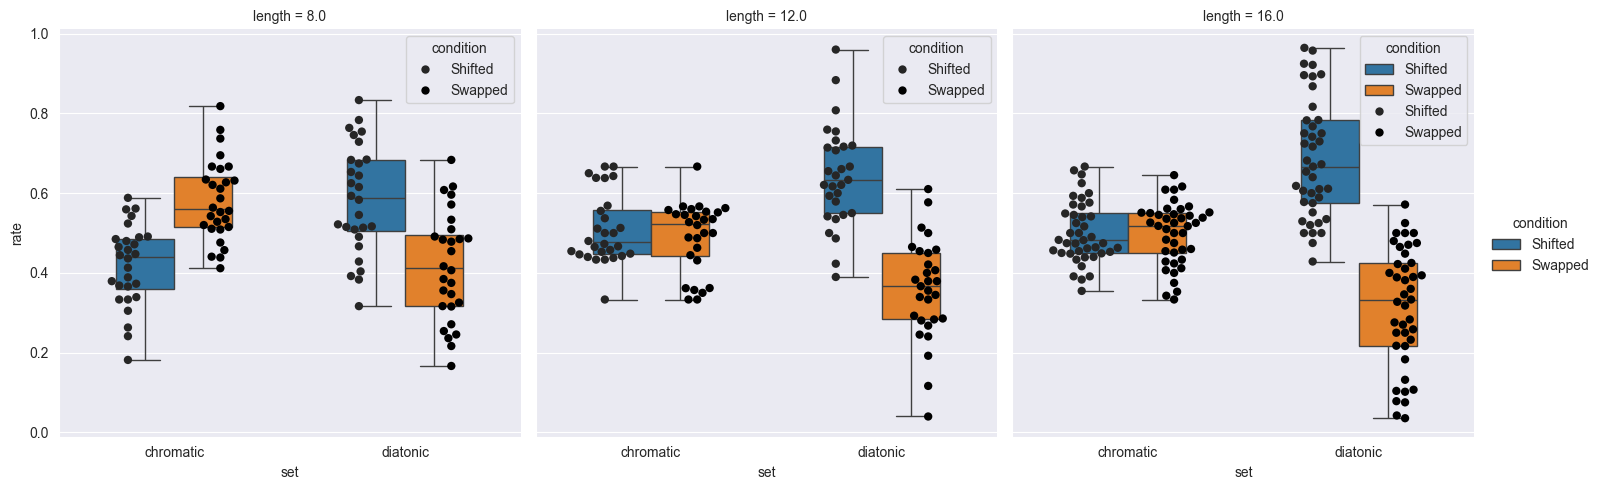

In [7]:
# Study I: Rate of shifted and swapped across all lengths (ignoring neithers)
temp = studyI_GL
temp = temp[['rate_NN_shifted','rate_NN_swapped','length','set']]
temp2 = pd.melt(temp,id_vars=["length","set"],var_name="condition",value_name="rate")
temp2['condition'] = temp2['condition'].replace('rate_NN_shifted',"Shifted")
temp2['condition'] = temp2['condition'].replace('rate_NN_swapped',"Swapped")

ax = sns.catplot(x="set", y="rate", data=temp2, col="length", kind="box", hue="condition", fliersize=0.5, width=0.5, height=5, aspect=1)
# ax = sns.catplot(x="set", y="rate", data=temp2, col="length", kind="swarm", hue="condition", dodge=True, height=5, aspect=1.57, ax=ax)
only_data_with_length_8 = temp2[temp2['length']==8]
sns.swarmplot(data=only_data_with_length_8, x="set", y="rate", hue="condition", palette='dark:black', dodge=True, ax=ax.axes[0][0], size=6)

only_data_with_length_12= temp2[temp2['length']==12]
sns.swarmplot(data=only_data_with_length_12, x="set", y="rate", hue="condition", palette='dark:black', dodge=True, ax=ax.axes[0][1], size=6)

only_data_with_length_16= temp2[temp2['length']==16]
sns.swarmplot(data=only_data_with_length_16, x="set", y="rate", hue="condition", palette='dark:black', dodge=True, ax=ax.axes[0][2], size=6)

# plt.ylim([0.2,0.8])
plt.savefig(StudyI_paths.plots_dir + "rate of shifted AND swapped (NN).svg")

## Run Statistics for Expt.1 (one-sample t-test over differences)

In [8]:
if Run_Stats:
    # 8-notes (one-way t-test)
    note_8_chromatic = only_data_with_length_8[only_data_with_length_8['set']=='chromatic']
    note_8_pentatonic = only_data_with_length_8[only_data_with_length_8['set']=='diatonic']

    [diff_8_note_chromatic, P_8_note_chromatic] = stats.ttest_1samp(note_8_chromatic[note_8_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    [diff_8_note_pentatonic, P_8_note_pentatonic] = stats.ttest_1samp(note_8_pentatonic[note_8_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    
    effect_size_8_note_pentatonic = cohen_d_one_sample(note_8_pentatonic[note_8_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    effect_size_8_note_chromatic = cohen_d_one_sample(note_8_chromatic[note_8_chromatic['condition']=='Shifted']['rate'].values, 0.5)

    # 12-notes (one-way t-test)
    note_12_chromatic = only_data_with_length_12[only_data_with_length_12['set']=='chromatic']
    note_12_pentatonic = only_data_with_length_12[only_data_with_length_12['set']=='diatonic']

    [diff_12_note_chromatic, P_12_note_chromatic] = stats.ttest_1samp(note_12_chromatic[note_12_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    [diff_12_note_pentatonic, P_12_note_pentatonic] = stats.ttest_1samp(note_12_pentatonic[note_12_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    
    effect_size_12_note_pentatonic = cohen_d_one_sample(note_12_pentatonic[note_12_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    effect_size_12_note_chromatic = cohen_d_one_sample(note_12_chromatic[note_12_chromatic['condition']=='Shifted']['rate'].values, 0.5)

    # 16-notes (one-way t-test)
    note_16_chromatic = only_data_with_length_16[only_data_with_length_16['set']=='chromatic']
    note_16_pentatonic = only_data_with_length_16[only_data_with_length_16['set']=='diatonic']

    [diff_16_note_chromatic, P_16_note_chromatic] = stats.ttest_1samp(note_16_chromatic[note_16_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    [diff_16_note_pentatonic, P_16_note_pentatonic] = stats.ttest_1samp(note_16_pentatonic[note_16_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    
    effect_size_16_note_pentatonic = cohen_d_one_sample(note_16_pentatonic[note_16_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    effect_size_16_note_chromatic = cohen_d_one_sample(note_16_chromatic[note_16_chromatic['condition']=='Shifted']['rate'].values, 0.5)

In [15]:
# Runs mixed anova (length x set) on rate of shifted and swapped
if Run_Stats:
    temp = studyI_GL
    temp = temp[['subject', 'rate_NN_shifted','rate_NN_swapped','length','set']]
    temp.loc[:,'rate_NN_shifted'] = temp.loc[:,'rate_NN_shifted'].astype('float')
    temp.loc[:,'length'] = temp.loc[:,'length'].astype('object')
    temp.reset_index(inplace=True)
    temp = temp.drop(['index'], axis=1)
    results = pg.mixed_anova(dv='rate_NN_shifted', between='length',
                             within='set', subject='subject', data=temp)

## Figure 2 - Study II - Rate of shifted-rate of swapped when ignoring neither trials

In [16]:
temp =studyII_GL
plot_order = temp.groupby('set').mean().sort_values(by=["rate shifted - rate swapped (NN)"], ascending=False).index.values
fig, ax = plt.subplots(figsize=(16, 16))
sns.pointplot(ax=ax, y="set", x="rate shifted - rate swapped (NN)", data=temp, order=plot_order,join=False, ci=0)
plt.savefig(ROOT_DIR + "/Plots/Study II 66 set distribution.svg")

TypeError: agg function failed [how->mean,dtype->object]

In [9]:
temp =studyII_GL
plot_order = temp.groupby('set').mean().sort_values(by=["rate shifted - rate swapped (NN)"], ascending=True).index.values
# plot_order = [s for index, s in enumerate(plot_order) if index%5==0]
# print(plot_order)
# temp = temp[temp['set'].isin(plot_order)]
fig, ax = plt.subplots(figsize=(7, 5))
sns.pointplot(ax=ax, x="set", y="rate shifted - rate swapped (NN)", data=temp, order=plot_order,join=False, ci=0)
plt.savefig(ROOT_DIR + "/Plots/Study II 66 set distribution-flipped.svg")

TypeError: agg function failed [how->mean,dtype->object]

## Figure 4 - Comparing Study I to Study II


/var/folders/bm/tx0fw97s0w5020l7n7hth5mc0000gn/T/ipykernel_8775/1718469973.py:22: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=new_df, x="group", y="rate shifted - rate swapped (NN)", hue="study", order=['worst','pentatonic'], color='black', dodge=True, size=5)


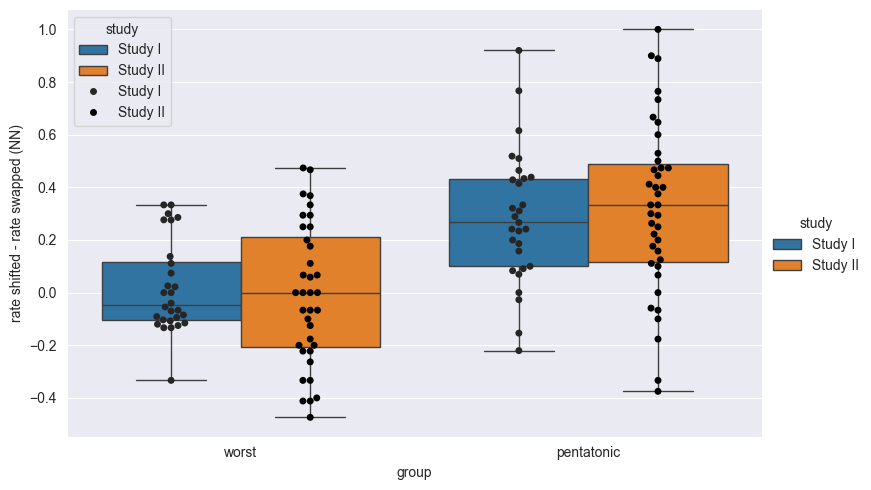

In [10]:
st1 = studyI_GL
st1 = st1[st1['length']==12].reset_index()
s1_best = st1[st1['set']=='diatonic'].reset_index(drop=True)
s1_best['group']='pentatonic'
s1_worst = st1[st1['set']!='diatonic'].reset_index(drop=True)
s1_worst['group']='worst'
st1 = pd.concat([s1_best,s1_worst]).reset_index(drop=True)
st1['study'] = "Study I"


st2 = studyII_GL
st2 = st2[st2['set'].isin(['0 2 4 7 9', '0 1 2 4 8'])].reset_index()
s2_best = st2[st2['set']=='0 2 4 7 9'].reset_index(drop=True)
s2_best['group']='pentatonic'
s2_worst = st2[st2['set']=='0 1 2 4 8'].reset_index(drop=True)
s2_worst['group']='worst'
st2 = pd.concat([s2_best,s2_worst]).reset_index(drop=True)
st2['study'] = "Study II"
new_df = pd.concat([st1,st2]).reset_index(drop=True)
ax = sns.catplot(x="group", y="rate shifted - rate swapped (NN)", data=new_df, kind="box", hue="study", order=['worst','pentatonic'], height=5, aspect=1.57)
# ax = sns.catplot(x="set", y="rate", data=temp2, col="length", kind="box", hue="condition", fliersize=0.5, width=0.5, height=5, aspect=1)
sns.swarmplot(data=new_df, x="group", y="rate shifted - rate swapped (NN)", hue="study", order=['worst','pentatonic'], color='black', dodge=True, size=5)
plt.savefig(ROOT_DIR + "/Plots/Study I vs. Study II best and worst.svg")

## Statistics Expt 2: Across study comparisons

In [25]:
if Run_Stats:

    new_df_study_1 = new_df[new_df['study'] == 'Study I']
    new_df_study_1_worst = new_df_study_1[new_df_study_1['group'] == 'worst']
    new_df_study_1_pentatonic = new_df_study_1[new_df_study_1['group'] == 'pentatonic']
    new_df_study_2 = new_df[new_df['study'] == 'Study II']
    new_df_study_2_worst = new_df_study_2[new_df_study_2['group'] == 'worst']
    new_df_study_2_pentatonic = new_df_study_2[new_df_study_2['group'] == 'pentatonic']

# worse vs. worse (study 1 vs. study 2)
[observation, p] = stats.ttest_ind(new_df_study_1_worst["rate shifted - rate swapped (NN)"], new_df_study_2_worst["rate shifted - rate swapped (NN)"])

effect_size_worst_v_worst = cohen_d_independent_t_test(new_df_study_1_worst["rate shifted - rate swapped (NN)"], new_df_study_2_worst["rate shifted - rate swapped (NN)"])
    
# pentatonic vs. pentatonic (study 1 vs. study 2)
[observation, p] = stats.ttest_ind(new_df_study_1_pentatonic["rate shifted - rate swapped (NN)"], new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"])

effect_size_pentatonic_v_pentatonic = cohen_d_independent_t_test(new_df_study_1_pentatonic["rate shifted - rate swapped (NN)"], new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"])

# worse vs. pentatonic (study 2 only)
[observation, p] = stats.ttest_ind(new_df_study_2_worst["rate shifted - rate swapped (NN)"], new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"])

## Figure 5 - Scale Selection
### Krunhansl Correlation

9999 of 10000p = 0.0
obs_stat = 0.5715047929806619


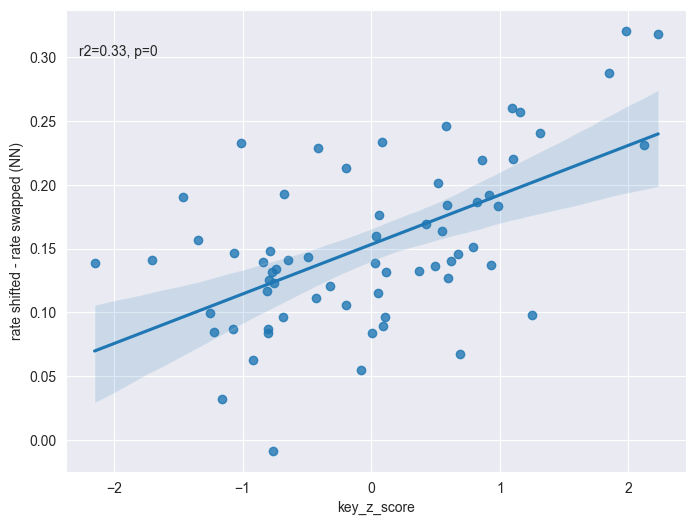

In [11]:
studyII_GL['key_z_score'] = zscore(studyII_GL['key_r'])
correlation(dataset=studyII_GL, x='key_z_score', y='rate shifted - rate swapped (NN)', normalize=False, type='pearson')
plt.savefig(ROOT_DIR + "/Plots/Study II key clarity correlation.svg")

9999 of 10000p = 0.0109
obs_stat = 0.30786676814060215
PearsonRResult(statistic=0.30786676814060215, pvalue=0.01191211988453417)
0.30786676814060215


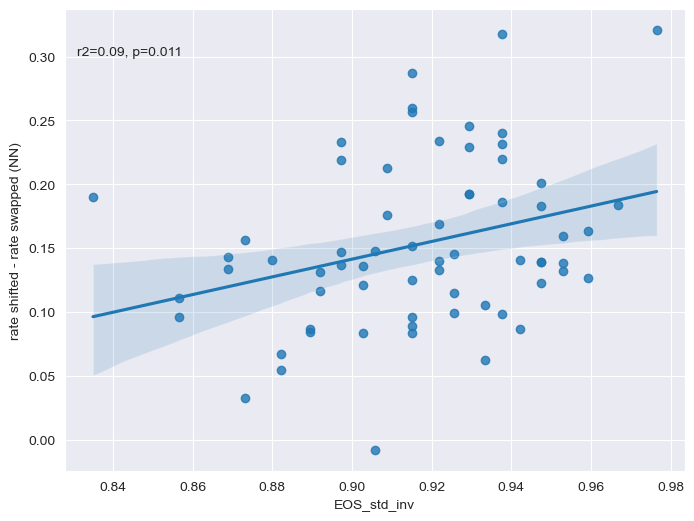

In [13]:
studyII_GL['EOS_std_inv'] = 1-studyII_GL['EOS_std']
correlation(x="EOS_std_inv", normalize=False, diatonic="include", dataset=studyII_GL)
plt.savefig(ROOT_DIR + "/Plots/Study II std of error from perfect evenness correlation.svg")

if Run_Stats:
    temp = studyII_GL #loading dataset
    temp = temp.groupby("set").mean(numeric_only=True).reset_index() #collapsing subject by set
    stat_no_perm = stats.pearsonr(temp["EOS_std_inv"], temp["rate shifted - rate swapped (NN)"])
    print(stat_no_perm)
    print(stat_no_perm[0])

### Likert Ratings
#### "Some notes felt more important than others." correlation with scores

In [12]:
s2 = studyII_GL.groupby('set').mean().reset_index()[['set','rate shifted - rate swapped (NN)']]
likert_corr = study_likert.merge(s2, on='set')
correlation(dataset=likert_corr,x='Q1 Mean', y='rate shifted - rate swapped (NN)', type='pearson', normalize=False)

if Run_Stats:
    stat_no_perm = stats.pearsonr(likert_corr["Q1 Mean"], likert_corr["rate shifted - rate swapped (NN)"])

TypeError: agg function failed [how->mean,dtype->object]

#### "The audio clip was melodic." correlation with scores

9999 of 10000p = 0.0
obs_stat = 0.5248554957089119


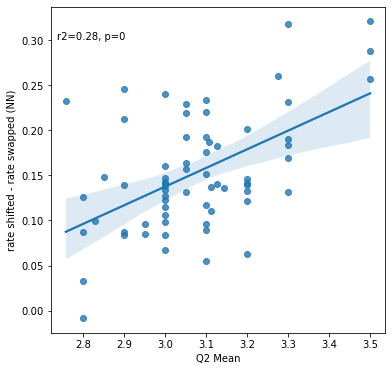

In [4]:
s2 = studyII_GL.groupby('set').mean().reset_index()[['set','rate shifted - rate swapped (NN)']]
likert_corr = study_likert.merge(s2, on='set')
correlation(dataset=likert_corr,x='Q2 Mean', y='rate shifted - rate swapped (NN)', type='pearson', normalize=False)

if Run_Stats:
    stat_no_perm = stats.pearsonr(likert_corr["Q2 Mean"], likert_corr["rate shifted - rate swapped (NN)"])

#### "The melody as a whole or parts of it felt familiar." correlation with scores

9999 of 10000p = 0.0626
obs_stat = 0.2299318711064302


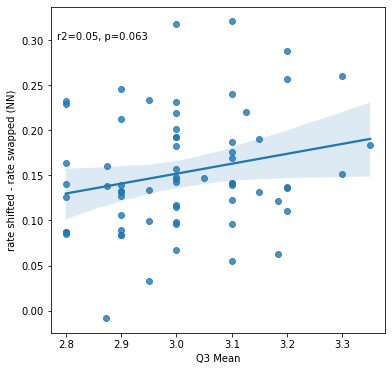

In [5]:
s2 = studyII_GL.groupby('set').mean().reset_index()[['set','rate shifted - rate swapped (NN)']]
likert_corr = study_likert.merge(s2, on='set')
correlation(dataset=likert_corr,x='Q3 Mean', y='rate shifted - rate swapped (NN)', type='pearson', normalize=False)

if Run_Stats:
    stat_no_perm = stats.pearsonr(likert_corr["Q3 Mean"], likert_corr["rate shifted - rate swapped (NN)"])

9999 of 10000p = 0.0
obs_stat = -0.5257754292897638


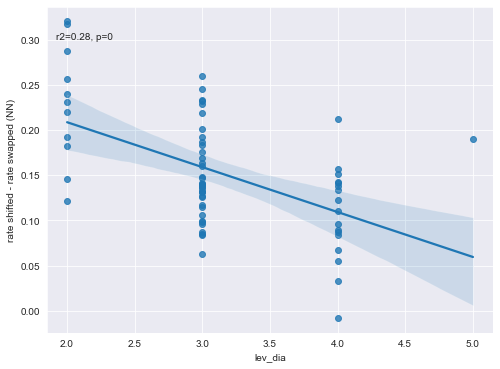

In [44]:
correlation(dataset=studyII_GL, x='lev_dia', y='rate shifted - rate swapped (NN)', normalize=False, type='pearson')

9999 of 10000p = 0.0243
obs_stat = -0.2802290559511709


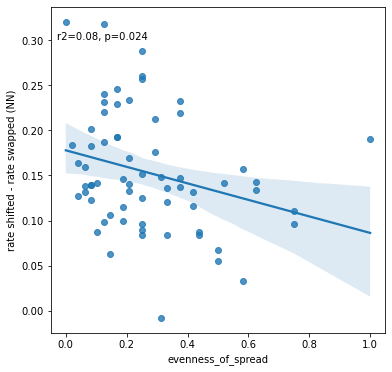

In [12]:
correlation(dataset=studyII_GL, x='evenness_of_spread', y='rate shifted - rate swapped (NN)', normalize=True, type='pearson')

### Ridge Regression of Interval contribution

In [24]:
ridge_coeffs(dataset=studyII_GL, X_vars=['IC1','IC2','IC3','IC4','IC5','IC6'], y_vars='rate shifted - rate swapped (NN)')
plt.savefig(StudyII_paths.plots_dir + "interval vector coeffs.svg")

TypeError: agg function failed [how->mean,dtype->object]

9999 of 10000p = 0.0167
obs_stat = -0.29340389443290293


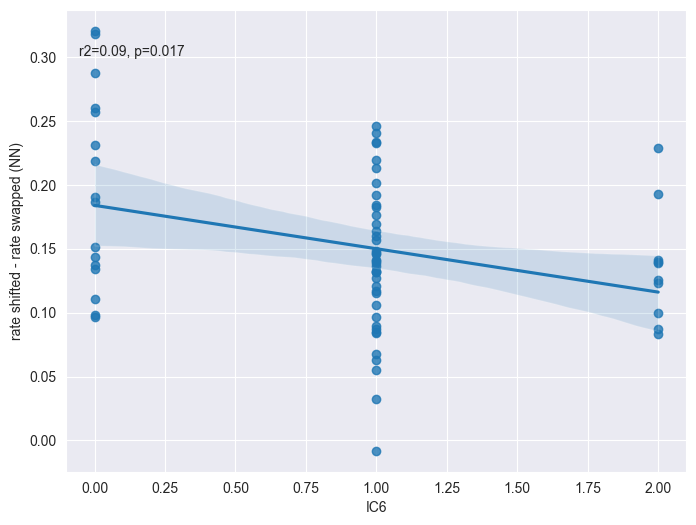

In [14]:
correlation(dataset=studyII_GL, x='IC6', y='rate shifted - rate swapped (NN)', normalize=False, type='spearman')

9999 of 10000p = 0.0194
obs_stat = -0.2798193355871201


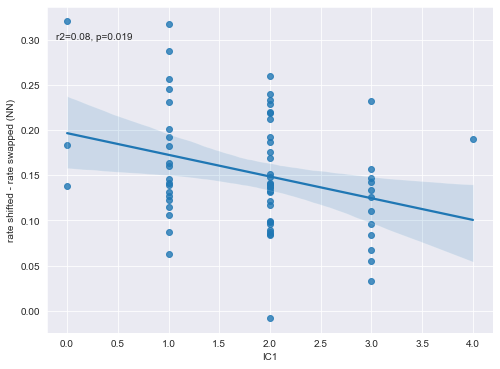

In [7]:
correlation(dataset=studyII_GL, x='IC1', y='rate shifted - rate swapped (NN)', normalize=False, type='spearman')

9999 of 10000p = 0.2861
obs_stat = -0.13601866588828673


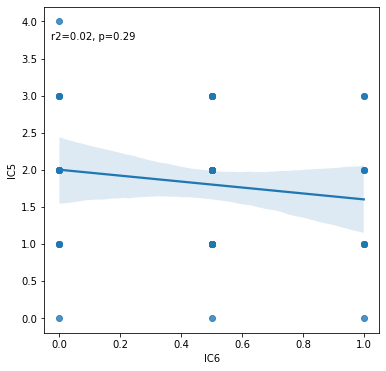

In [11]:
correlation(dataset=studyII_GL, x='IC6', y='rate shifted - rate swapped (NN)', normalize=True, type='spearman')

9999 of 10000p = 0.2993
obs_stat = 0.1291977349324894


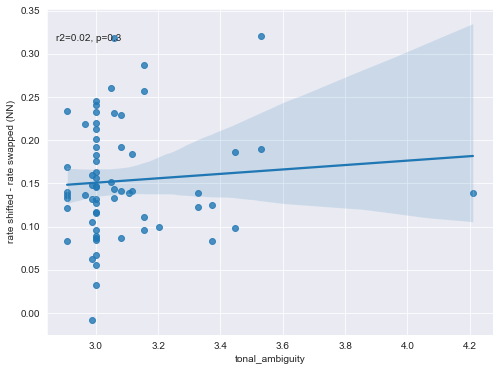

In [14]:
correlation(dataset=studyII_GL, x='tonal_ambiguity', y='rate shifted - rate swapped (NN)', normalize=False, type='spearman')

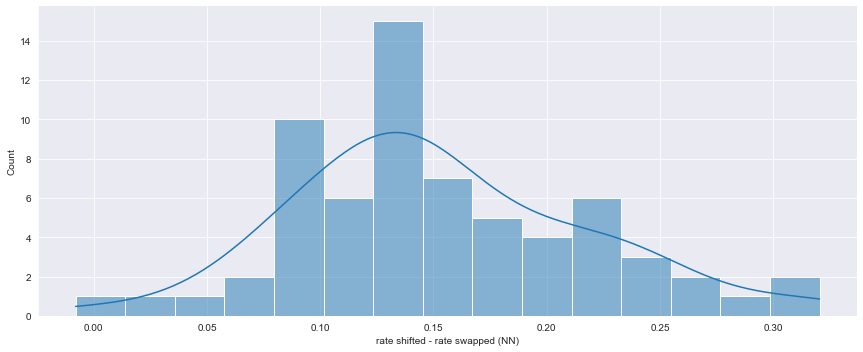

In [11]:
temp = studyII_GL.groupby("set").mean().reset_index() #collapsing subject by set
sns.displot(x="rate shifted - rate swapped (NN)",data=temp, kde=True, aspect=2.42, bins=15)
plt.savefig(ROOT_DIR + "/Plots/rate of shifted AND swapped (NN) distribution.svg")

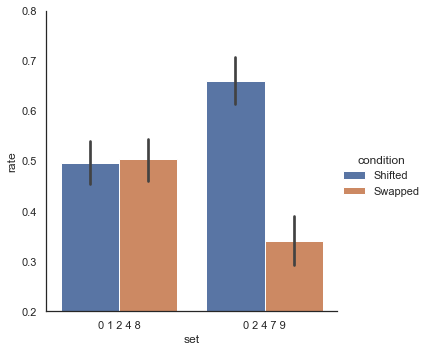

In [28]:
# Study I: Rate of shifted and swapped across all lengths (ignoring neithers)
temp = studyII_GL
temp = temp[temp['set'].isin(['0 2 4 7 9', '0 1 2 4 8'])]
temp['set']
temp = temp[['rate_NN_shifted','rate_NN_swapped','set']]
temp2 = pd.melt(temp,id_vars=["set"],var_name="condition",value_name="rate")
temp2['condition'] = temp2['condition'].replace('rate_NN_shifted',"Shifted")
temp2['condition'] = temp2['condition'].replace('rate_NN_swapped',"Swapped")
sns.catplot(x="set", y="rate", data=temp2, kind="bar", hue="condition", order=['0 1 2 4 8', '0 2 4 7 9'])
plt.ylim([0.2,0.8])
plt.savefig(StudyII_paths.plots_dir + "rate of shifted AND swapped (NN) best and worst.svg")

9999 of 10000p = 0.0124
obs_stat = -0.3078667820488072


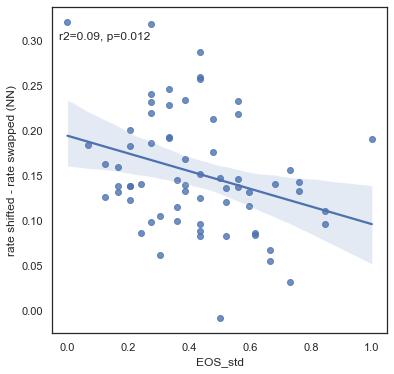

In [13]:
correlation(studyII_GL,x='EOS_std')

9999 of 10000p = 0.0069
obs_stat = -0.3275767905879568


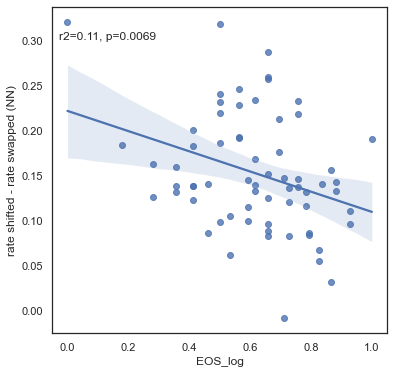

In [11]:
correlation(studyII_GL,x='EOS_log')

9999 of 10000p = 0.0028
obs_stat = -0.3598073881209174


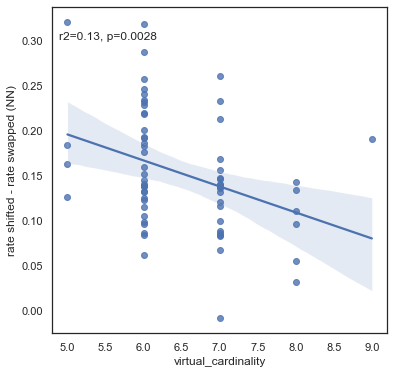

In [7]:
correlation(studyII_GL,x='virtual_cardinality', type='spearman', normalize=False)

9999 of 10000p = 0.0447
obs_stat = 0.25331958532025506


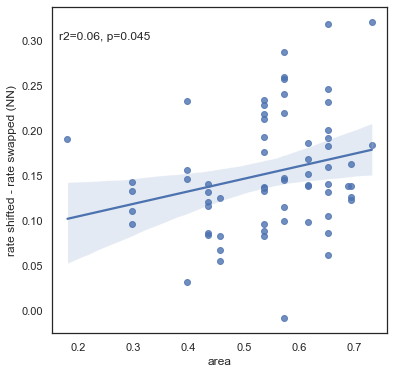

In [15]:
correlation(studyII_GL,x='area', type='pearson', normalize=False)

9999 of 10000p = 0.2346
obs_stat = -0.14839071684837798


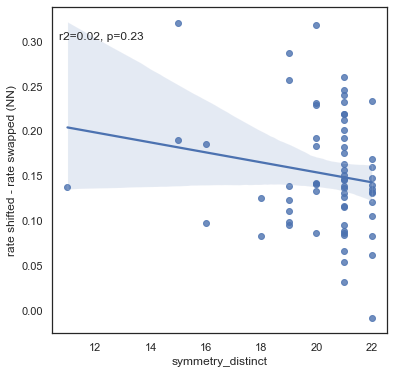

In [10]:
correlation(studyII_GL,x='symmetry_distinct', type='pearson', normalize=False)

9999 of 10000p = 0.006
obs_stat = 0.341614610464812


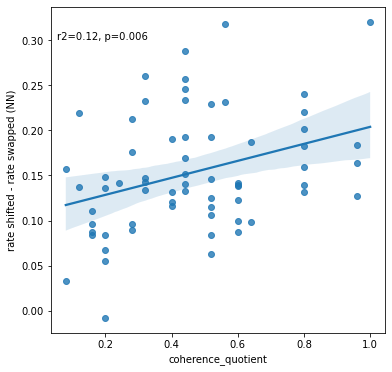

In [16]:
correlation(studyII_GL,x='coherence_quotient', normalize=False, diatonic='include')

9999 of 10000p = 0.0007
obs_stat = 0.7688539286732973


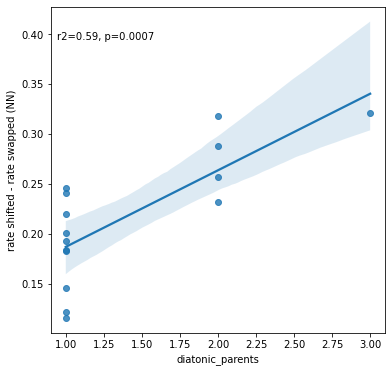

In [19]:
correlation(studyII_GL,x='diatonic_parents', normalize=False, diatonic='only', type="spearman")

9999 of 10000p = 0.0042
obs_stat = 0.3441668580115853


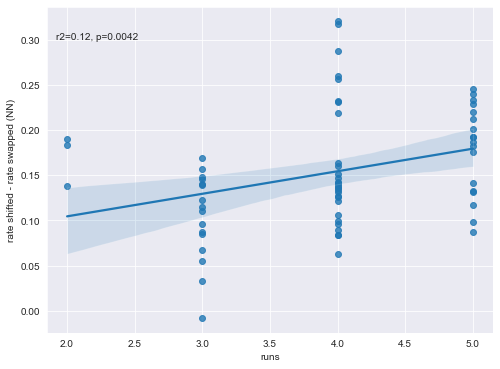

In [5]:
correlation(studyII_GL,x='runs', normalize=False, diatonic='include', type="spearman")

****Ridge regression:***
Score: 0.16597762266840888
 coeffs: 
symmetry_distinct     -0.011049
virtual_cardinality   -0.031658
unevenness             0.011027
step_similarity        0.000140
dtype: float64

Computing confidence intervals.
['symmetry_distinct', 'virtual_cardinality', 'unevenness', 'step_similarity']
DONE.

Running Permutation Tests.
9999 of 10000DONE.

Plotting:


C:\Users\Michael\Documents\PycharmProjects\Scale_Studies - For Paper\Shared_Scripts\plotting_functions.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 3), size=13)


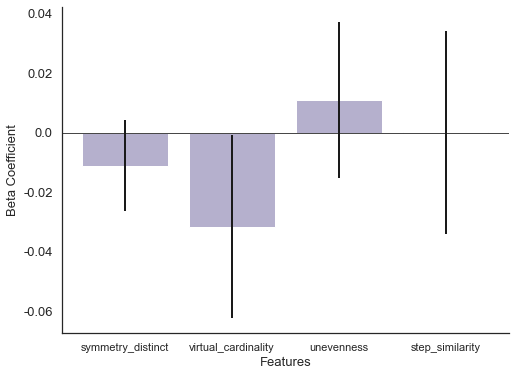

In [14]:
ridge_coeffs(dataset=studyII_GL, X_vars=['symmetry_distinct','virtual_cardinality','unevenness','step_similarity'], y_vars='rate shifted - rate swapped (NN)')
# plt.savefig(StudyII_paths.plots_dir + "interval vector coeffs.svg")

9999 of 10000p = 0.0425
obs_stat = 0.28624939358722634


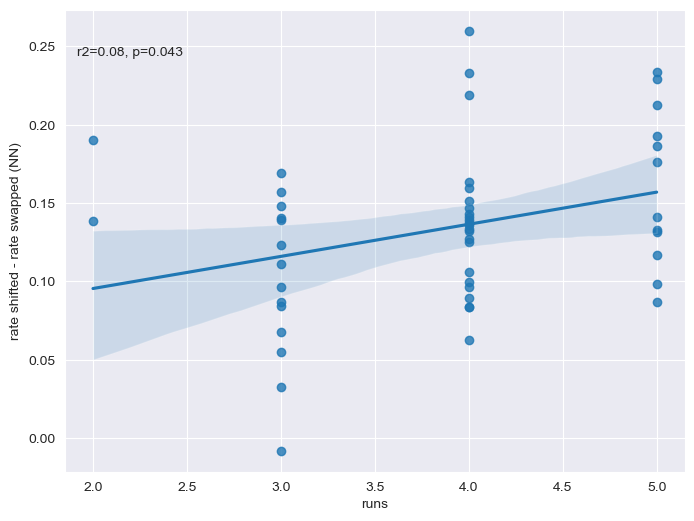

In [10]:
correlation(studyII_GL,x='runs', normalize=False, diatonic='only', type="spearman")

9999 of 10000p = 0.0
obs_stat = -0.9056991672552047


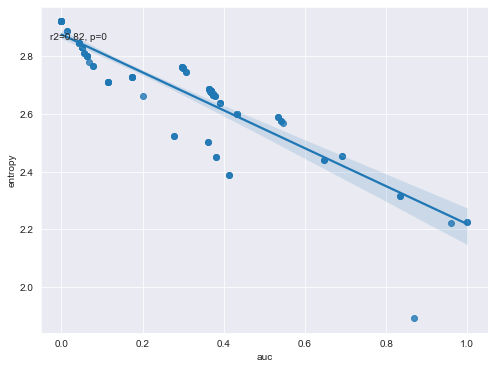

In [31]:
correlation(ambiguity,x='auc', y='entropy')

Uniform Sets Basic Results

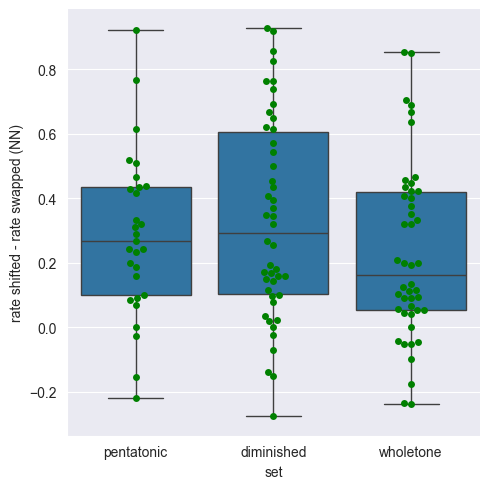

In [9]:
st1 = studyI_GL
st1 = st1[st1['length']==12].reset_index()
st1 = st1[st1['set']=='diatonic'].reset_index(drop=True)
st1['study'] = "Exp. 1"

st3 = study_uniform
st3['study'] = "Exp. 3"

new_df = pd.concat([st1,st3]).reset_index(drop=True)

new_df['set'] = new_df['set'].replace('diatonic','pentatonic')
new_df['set'] = new_df['set'].replace('0 2 4 7 9','pentatonic')


ax=sns.catplot(x="set", y="rate shifted - rate swapped (NN)", data=new_df, kind='box')
sns.swarmplot(data=new_df, x="set", y="rate shifted - rate swapped (NN)", color='green', dodge=True, size=5)

plt.savefig(ROOT_DIR + "/Plots/exp3 and exp1 results.svg")

## Statistics Expt 3: Across study comparisons
### One-way T-Test for individual sets

In [19]:
Run_Stats = True
if Run_Stats:
    # 8-notes (one-way t-test)
    diminished = new_df[new_df['set']=='diminished']
    wholetone = new_df[new_df['set']=='wholetone']
    pentatonic = new_df[new_df['set']=='pentatonic']

    [diff_diminished, P_diminished] = stats.ttest_1samp(diminished['rate_NN_shifted'].values, 0.5)
    [diff_WT, P_WT] = stats.ttest_1samp(wholetone['rate_NN_shifted'].values, 0.5)
    print(P_diminished, P_WT)
    print(diff_diminished, diff_WT)
    
    effect_size_diminished = cohen_d_one_sample(diminished['rate_NN_shifted'].values, 0.5)
    
    effect_size_wholetone = cohen_d_one_sample(wholetone['rate_NN_shifted'].values, 0.5)

4.176142500999187e-09 7.652614219613734e-07
7.261687699988692 5.73727844874311


### Comparison with Pentatonic

In [21]:
if Run_Stats:

    # diminished vs. pentatonic
    [diminished_v_penta_T, diminished_v_penta_P] = stats.ttest_ind(pentatonic['rate_NN_shifted'].values, diminished['rate_NN_shifted'].values)
    
    effect_size_diminished_v_penta = cohen_d_independent_t_test(pentatonic['rate_NN_shifted'].values, diminished['rate_NN_shifted'].values)
    
    # wholetone vs. pentatonic 
    [wholetone_v_penta_T, wholetone_v_penta_P] = stats.ttest_ind(pentatonic['rate_NN_shifted'].values, wholetone['rate_NN_shifted'].values)
    
    effect_size_wholetone_v_penta = cohen_d_independent_t_test(pentatonic['rate_NN_shifted'].values, wholetone['rate_NN_shifted'].values)
    
    print(diminished_v_penta_P, wholetone_v_penta_P)
    print(diminished_v_penta_T, wholetone_v_penta_T)

0.46875246958981565 0.39766624564054087
-0.7283120705243783 0.8507934006185681
